# Poor Conditioning (Section 4.3)

In [1]:
import numpy as np
import pandas as pd
from linear_regression import LinearRegression
import algorithms
import postprocessing
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import scipy.linalg
import itertools

## Data Generation

In [2]:
np.random.seed(2)

total_observations = 1010
num_observations_pop_1 = 10 # A (small fraction)
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

# Generate X values.
mean_pop_1 = np.array([-1])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[.01]])
vars_pop_2 = np.array([[1e-3]])
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)
x1_0 = [pt[0] for pt in x1]
x2_0 = [pt[0] for pt in x2]

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:10]
x2 = x[10:]

# Generate Y values.
epsilon = np.random.normal(0, 1, num_observations_pop_1) # eps is the variance of the noise distribution.
slope = -1
intercept = -10

y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope*x1_0[i] + intercept + epsilon[i])

y2 = np.random.randn(1, num_observations_pop_2)
y2 = y2[0]
y = np.concatenate([y1, y2], axis=0)

In [ ]:
# x_nointercept = x[:,1].reshape(-1,1)
# x1_nointercept = x1[:,1].reshape(-1,1)
# x2_nointercept = x2[:,1].reshape(-1,1)

In [3]:
# Compute condition numbers
print(
    f"Condition number of full dataset: {np.linalg.cond(x)}\n"
    f"Condition number Pop A: {np.linalg.cond(x1)} Pop B: {np.linalg.cond(x2)}"
)

Condition number of full dataset: 9.073893742551537
Condition number Pop A: 20.258489328645023 Pop B: 31.680064947455453


## Model Fitting

Fit the data using OLS regression.

In [4]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}\n"
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
) 

Estimated beta1 with full dataset: 7.402664577586842
Estimated beta1 pop B: -1.0492493650237367


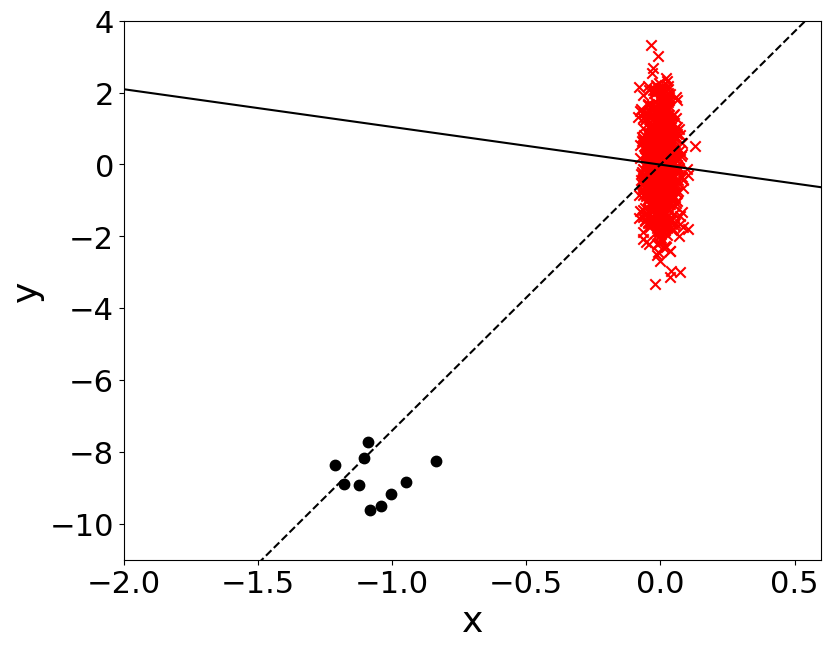

In [5]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:, 1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:, 1], y2, marker='x', color='r', label='Pop. B', s=56)

x_values = np.linspace(-2, 0.6, 100)
y_values_full = lr.beta[1] * x_values + lr.beta[0]
y_value_red_crosses = modified_lr.beta[1] * x_values + modified_lr.beta[0]
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.ylim(-11, 4)
plt.xlim(-2, 0.6)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

 # plt.legend(fontsize=22)
# plt.savefig('poor_conditioning_example_5.pdf')
plt.show()

### Net Approx. Algorithm

In [6]:
Xnet = np.zeros((x.shape[0],x.shape[1]))
Xnet[:,0] =  x[:,1]
Xnet[:,1] =  x[:,0]

In [8]:
trials = 1000 # MR23: "trials should be chosen as large as possible subject to computational constraints."
n_sumwstar, wstar = algorithms.net_algorithm(Xnet,y,1000)
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indices of the MIS.
alphaN = 10
mis_inds = np.argsort(wstar)[:alphaN]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 10.161411616444639


array([0, 1, 3, 4, 5, 6, 7, 8, 9, 2])

### FH-Gurobi (warm start)

In [9]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x, y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 2020 rows, 1012 columns and 2020 nonzeros
Model fingerprint: 0x674fed38
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-07, 1e+00]
  QLMatrix range   [1e-07, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2020 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 2020 rows and 0 columns
Presolve time: 0.01s
Presolved: 8082 rows, 3033 columns, 22220 nonzeros
Presolved model has 2020 bilinear con

In [10]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x, y, intercept=True, time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1013 columns and 1 nonzeros
Model fingerprint: 0xd967496a
Model has 3 quadratic constraints
Variable types: 3 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [4e-10, 1e+00]
  QLMatrix range   [1e-07, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

User MIP start produced solution with objective 1000 (0.00s)
Loaded user MIP start with objective 1000

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 6062 rows, 10103 columns, 23229 nonzeros
Presolved model has 6060 SOS constraint(s)
Variable types: 6063

In [11]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### FH-Gurobi (no warm start)

In [12]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x[:,1],y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1012 columns and 1 nonzeros
Model fingerprint: 0x9107a156
Model has 2 quadratic constraints
Variable types: 2 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [4e-10, 1e+00]
  QLMatrix range   [1e-07, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 4042 rows, 7072 columns, 16159 nonzeros
Presolved model has 4040 SOS constraint(s)
Variable types: 4042 continuous, 3030 integer (3030 binary)

Root relaxation: o

In [13]:
weights_array = np.array([w.X for w in weights])

In [14]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(weights_array == 0)[0]
indices_to_remove

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         12,   13,   14,   15,   16,   17,   18,   19,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
         35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,
         46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   60,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   70,   71,   72,   73,   74,   76,   77,   78,   79,   80,
         81,   82,   84,   85,   86,   87,   88,   89,   91,   92,   93,
         94,   95,   96,   97,   98,   99,  100,  101,  102,  103,  104,
        105,  106,  107,  109,  110,  111,  112,  113,  114,  115,  116,
        117,  118,  119,  120,  121,  123,  124,  125,  126,  127,  128,
        129,  130,  131,  132,  133,  134,  135,  137,  139,  140,  141,
        143,  144,  145,  146,  147,  148,  149,  150,  151,  152,  153,
        154,  155,  156,  157,  158,  159,  160,  1

In [15]:
len(indices_to_remove)

900

#### Refit after Removing Flagged Points.

In [16]:
Gurobi_inds= indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(110, 2)
(110,)


In [17]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by NetApprox: {modified_lr_na.beta[1]}"
)

Estimated beta1 with full dataset: 7.402664577586842
Estimated beta1 after removing subset specified by NetApprox: -3.9019471371316086


## Additive and Greedy algorithms.

#### Additive Algorithms.

In [19]:
poor_conditioning_df = postprocessing.compute_scores(x, y, lr, True)

In [20]:
poor_conditioning_df.head(10)

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1.0,-9.512121,-1.798067,0.087423,-0.000006,-0.000007,302,302,-0.003457,-0.003460
1,1.0,-9.158502,-1.711308,0.081478,0.000054,0.000058,30,30,-0.003055,-0.003058
2,1.0,-8.361579,0.625317,0.118695,0.000106,0.000120,400,400,-0.002831,-0.002834
3,1.0,-8.250522,-2.059217,0.056343,0.000402,0.000426,482,482,-0.002705,-0.002708
4,1.0,-8.894897,-0.161736,0.112076,-0.000022,-0.000025,605,605,-0.002533,-0.002536
5,1.0,-9.614648,-1.585989,0.094704,-0.000070,-0.000078,67,67,-0.002415,-0.002417
6,1.0,-8.832092,-1.798817,0.072676,0.000153,0.000165,942,942,-0.002317,-0.002320
7,1.0,-8.917402,-0.590015,0.101890,-0.000049,-0.000055,297,297,-0.002299,-0.002301
8,1.0,-8.165146,0.023563,0.098521,0.000002,0.000002,373,373,-0.002299,-0.002301
9,1.0,-7.730504,0.347946,0.095884,0.000018,0.000020,862,862,-0.002297,-0.002299


In [22]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(poor_conditioning_df["sorted_IF_scores"][:9]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is {round(lr.beta[1] + sum(poor_conditioning_df["sorted_1Exact_scores"][:9]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most 10 is {round((modified_lr.beta[1]), 4)}.')

The AMIP approximation of the refit is 7.3788.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is 7.3787.
The true change induced by dropping the worst-case subset of size at most 10 is -1.0492.


In [23]:
#### Refit after Removing Flagged Points.
new_x= np.delete(x, poor_conditioning_df["sorted_IF_indices"][:10], axis=0)
new_y= np.delete(y, poor_conditioning_df["sorted_IF_indices"][:10], axis=0)
print(new_x.shape)
print(new_y.shape)

new_x_1exact= np.delete(x, poor_conditioning_df["sorted_1Exact_indices"][:10], axis=0)
new_y_1exact= np.delete(y, poor_conditioning_df["sorted_1Exact_indices"][:10], axis=0)
print(new_x_1exact.shape)
print(new_y_1exact.shape)

(1000, 2)
(1000,)
(1000, 2)
(1000,)


In [24]:
modified_lr_amip = LinearRegression(x=new_x.T, y=new_y)
modified_lr_amip.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr_amip.beta[1]}"
)
modified_lr_1exact = LinearRegression(x=new_x_1exact.T, y=new_y_1exact)
modified_lr_1exact.fit()
print(
    f"Estimated beta1 after removing subset specified by 1Exact: {modified_lr_1exact.beta[1]}"
)

Estimated beta1 after removing subset specified by AMIP: 7.438475108884157
Estimated beta1 after removing subset specified by 1Exact: 7.438475108884157


### Greedy Approx

In [26]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = postprocessing.create_orig_df(orig_x, orig_y, lr, True)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

inds [  0   5   1   3   6   7   4 775 237 405]
newton_inds [  0   5   1   6   3   7   4 775 237 405]


In [27]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = algorithms.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, True, method='if')

print("dropped order: \n", dropped_order[:10])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:10])

iteration 0
index to remove (original): 0
fitted beta1: 7.237297821894756
iteration 1
index to remove (original): 5
fitted beta1: 7.048680282235854
iteration 2
index to remove (original): 1
fitted beta1: 6.821298417188832
iteration 3
index to remove (original): 6
fitted beta1: 6.550486937974007
iteration 4
index to remove (original): 3
fitted beta1: 6.243712631418109
iteration 5
index to remove (original): 7
fitted beta1: 5.904155963269849
iteration 6
index to remove (original): 4
fitted beta1: 5.437915365675767
iteration 7
index to remove (original): 8
fitted beta1: 4.788489548736089
iteration 8
index to remove (original): 2
fitted beta1: 3.374649144935868
iteration 9
index to remove (original): 9
fitted beta1: -1.0492493650237367
iteration 10
index to remove (original): 405
fitted beta1: -1.1874189437970155
iteration 11
index to remove (original): 527
fitted beta1: -1.3144341196483116
iteration 12
index to remove (original): 540
fitted beta1: -1.440933097093766
iteration 13
index to 

### Residual vs. Leverage Plot

In [ ]:
plt.figure(figsize=(9, 7))

plt.scatter(poor_conditioning_df['leverage'][:10], poor_conditioning_df['residual'][:10], marker='o', color='black', label='Pop. A', s=56)
plt.scatter(poor_conditioning_df['leverage'][10:], poor_conditioning_df['residual'][10:], marker='x', color='r', label='Pop. B', s=56)

plt.xlabel('Leverage', fontsize=26) 
plt.ylabel('Residual', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
# plt.savefig('poor_conditioning_levresid.pdf', bbox_inches='tight')
plt.show()

#### Greedy Algorithms.

In [ ]:
def create_orig_df(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression object.
    '''
    # compute IF/1Exact scores.
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # residuals
    residuals = lr.residual()
    # leverages
    leverages = lr.leverage_scores()
    # x's
    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': if_scores, 'newton': newton_scores})
    
    print(orig_df[:5])
    return orig_df, if_inds, if_scores, newton_inds, newton_scores

def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''

    # Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("Point to Drop: ", sorted_if_df.index[0])
    
    # sorted_if_df: the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    sorted_if_df['sorted_idx'] = index
    
    # Plot points dropped
    plt.figure(figsize=(9, 7))
    plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B

    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def Run_Greedy(x, y, orig_if_inds, orig_newton_inds, lr, method='IF'):
    '''
    x: design matrix.
    y: response vector.
    orig_inds: indices sorted by the first round.
    lr: linear regression object.
    method: 'IF' or '1Exact'.
    '''
    ctr = 0
    prev_beta = lr.beta[1] # initialize to the original beta estimate.
    dropped_order = []
    exact_changes_beta = []
    beta_estimates_greedy = []
    if_inds = orig_if_inds
    newton_inds = orig_newton_inds

    for _ in range(11):
        print(f'interation {ctr}')

        if method == 'IF':
            inds = if_inds
        else:
            inds = newton_inds
        
        # 1. drop the datapoint with the most negative influence:
        index_to_remove = inds[0]
        print("index to remove", index_to_remove)

        dropped_order.append(index_to_remove)

        new_x = np.concatenate((x[:index_to_remove], x[index_to_remove + 1:]))
        new_y = np.concatenate((y[:index_to_remove], y[index_to_remove + 1:]))

        x = new_x
        y = new_y

        # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
        lr = LinearRegression(x=x.T, y=y)
        lr.fit()
        print(f'fitted beta1: {lr.beta[1]}')

        # 3. compute scores and create plot.
        orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(x, y, lr)
        create_plot(orig_df)

        # 4. record: the exact change in beta.
        beta_change = lr.beta[1] - prev_beta
        exact_changes_beta.append(beta_change)
        prev_beta = lr.beta[1]
        beta_estimates_greedy.append(lr.beta[1])

        # counter
        ctr += 1

    return dropped_order, exact_changes_beta, beta_estimates_greedy


In [ ]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(orig_x, orig_y, lr)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

In [ ]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='1Exact')

print("dropped order: \n", dropped_order[:5])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:5])